#### json 형태의 라벨 데이터를 COCO 라이브러리를 통해 마스킹된 이미지 파일 형태로 변환

In [20]:
from pycocotools.coco import COCO
import numpy as np
import random
import os
import cv2
from PIL import Image
import skimage.io as io
import json
import pandas as pd
from tqdm import tqdm
from coco_data import Datasets
## For visualizing results
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [18]:
DATA_PATH = '.....'

In [58]:
df = pd.DataFrame(columns = ['index', 'Scratched', 'Breakage', 'Separated', 'Crushed', 'total_anns', 'dataset'])
df.head()

,index,Scratched,Breakage,Separated,Crushed,total_anns,dataset


In [30]:
label_fn = os.listdir(f'{DATA_PATH}label\\')
len(label_fn)

50445

In [31]:
label_fn[0]

'0506233_sc-202337.json'

In [59]:
# COCO 형식으로 마스킹 하기 위해 주어진 엑셀 파일 형태로 데이터를 만들기
# 각 이미지마다 클래스의 갯수를 카운트한다.
for i in tqdm(label_fn):
    scratched_count = 0
    breakage_count = 0
    separated_count = 0
    crushed_count = 0
    total_anns = 0
    name = i.split('.json')[0] + '.jpg'
    with open(f'{DATA_PATH}label\\{i}', "r", encoding = 'utf-8') as json_file:
        t = json.load(json_file)
    
    for j in t['annotations']:
        if j['damage'] == 'Breakage':
            breakage_count += 1
        elif j['damage'] == 'Scratched':
            scratched_count += 1
        
        elif j['damage'] == 'Separated':
            separated_count += 1
        
        elif j['damage'] == 'Crushed':
            crushed_count += 1
        
        else:
            pass
        
        total_anns = breakage_count + scratched_count + separated_count + crushed_count
        count_df = pd.DataFrame([[name, scratched_count, breakage_count, separated_count, crushed_count, total_anns, 'val']], columns = df.columns)

    df = pd.concat([df,count_df]).reset_index(drop = True)
df.head()

100%|██████████| 50445/50445 [35:12<00:00, 23.88it/s]    


,index,Scratched,Breakage,Separated,Crushed,total_anns,dataset
0,0506233_sc-202337.jpg,0,1,1,0,2,val
1,0506234_sc-202337.jpg,0,0,3,0,3,val
2,0506235_sc-202337.jpg,1,0,2,0,3,val
3,0506236_sc-202337.jpg,1,0,1,0,2,val
4,0506237_sc-202337.jpg,2,0,1,0,3,val


In [60]:
df.to_csv(f'{DATA_PATH}label_instance.csv', index = False)

In [5]:
# COCO 형태 데이터 생성
annFile= f'{DATA_PATH}datainfo\\damage_val.json'
coco=COCO(annFile)

loading annotations into memory...
Done (t=7.52s)
creating index...
index created!


In [6]:
# 카테고리 갯수
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

nms=[cat['name'] for cat in cats]
print(len(nms),'COCO categories: \n{}\n'.format(' '.join(nms)))

4 COCO categories: 
Scratched Separated Crushed Breakage



In [7]:
# 원하는 카테고리를 포함한 데이터의 갯수
catIds = coco.getCatIds(catNms='Scratched');
imgIds = coco.getImgIds(catIds=catIds);

print("Number of images containing all required classes:", len(imgIds))

Number of images containing all required classes: 17912


In [13]:
#COCO 형식으로 마스킹된 파일 저장하는 경로
MASK_SAVE_PATH = '....'

In [24]:
# coco 형식인 json 파일을 마스킹 하고 마스킹 결과를 256 x 256 으로 사이즈 통일
# 기존 데이터 확장자인 tif로 저장.
for i in tqdm(imgIds):    
    try:
        img = coco.loadImgs(i)[0]
        I = io.imread('{}\\train\\{}'.format(DATA_PATH,img['file_name']))/255.0
        fn = img['file_name'].split('.jpg')[0] + '.tif'
        annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
        anns = coco.loadAnns(annIds)
        for ann in anns:
            ann['segmentation'] = np.expand_dims(np.array(ann['segmentation']).flatten(), 0).tolist()

        image_shape = coco.imgs[anns[0]['image_id']]['height'], coco.imgs[anns[0]['image_id']]['width']
        masks = np.zeros(image_shape)

        for ann in anns:
            pixel_value = ann['category_id'] + 1
            masks = np.maximum(coco.annToMask(ann) * pixel_value, masks)
        
        scratch_masks = np.where(masks == 1, 255, 0)
        if len(np.unique(scratch_masks)) == 1 and np.unique(scratch_masks)[0] == 0:
            pass
        else:
            scratch_masks = Image.fromarray(scratch_masks).resize((256,256),0)
            scratch_masks.save(os.path.join(MASK_SAVE_PATH, fn), 'TIFF')
    except:
        # print(img['file_name'])
        pass


    

  2%|▏         | 126/8000 [00:23<38:00,  3.45it/s]<ipython-input-24-2eb3cbb837c2>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ann['segmentation'] = np.expand_dims(np.array(ann['segmentation']).flatten(), 0).tolist()
100%|██████████| 8000/8000 [23:22<00:00,  5.70it/s]


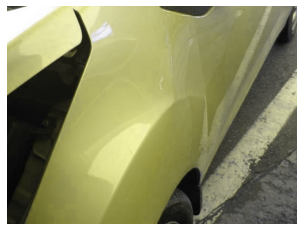

In [16]:
#원본 이미지 출력
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}\\train\\{}'.format(DATA_PATH,img['file_name']))/255.0
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)

for ann in anns:
    ann['segmentation'] = np.expand_dims(np.array(ann['segmentation']).flatten(), 0).tolist()
    
masks = np.zeros((600,800))

for ann in anns:
    pixel_value = ann['category_id'] + 1
    masks = np.maximum(coco.annToMask(ann) * pixel_value, masks)

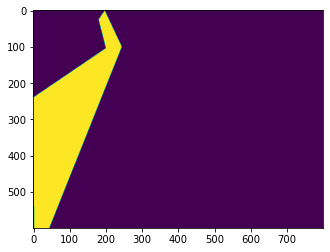

In [17]:
#마스킹 된 이미지 출력
plt.imshow(masks)